# Intelligent Crowd Scene Analytics
### Intelligent Sensing Systems Practice Module 2022

- Analytics engine capable of providing persistent monitoring on both indoor and outdoor static CCTVs to provide higher-order insights on crowd social behaviour
- Modules include:
    - Social Distancing Monitoring (COVID-19)
    - Crowd Management (Crowd Counting)
    - Crowd Anomaly (Flow Estimation/Stampede Alert)
    - Fall Detection (Medical Emergencies)
    - Violent Behaviour Detection (Fighting, assualt)

Team: Adriel Kuek, Chua Hao Zi, KC lim & Yap Pow Look

In [22]:
# Import
import torch
from IPython.display import Image, clear_output

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# limit the number of cpus used by high performance libraries
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import sys
sys.path.insert(0, './yolov5')

import argparse
import os
import platform
import shutil
import time
from pathlib import Path
import cv2
import torch
import torch.backends.cudnn as cudnn

from yolov5.models.experimental import attempt_load
from yolov5.utils.downloads import attempt_download
from yolov5.models.common import DetectMultiBackend
from yolov5.utils.datasets import LoadImages, LoadStreams
from yolov5.utils.general import (LOGGER, check_img_size, non_max_suppression, scale_coords, 
                                  check_imshow, xyxy2xywh, increment_path)
from yolov5.utils.torch_utils import select_device, time_sync
from yolov5.utils.plots import Annotator, colors
from deep_sort.utils.parser import get_config
from deep_sort.deep_sort import DeepSort

# FILE = Path(__file__).resolve()
ROOT = os.path.abspath('')
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

print(sys.path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Setup complete. Using torch 1.7.0 (TITAN Xp)
['./yolov5', './yolov5', '/home/user/Adriel/MTech-IS/GradCert_IntelligentSensing/ITSS_PracticeModule/ITSS', '/home/user/anaconda3/envs/itss/lib/python37.zip', '/home/user/anaconda3/envs/itss/lib/python3.7', '/home/user/anaconda3/envs/itss/lib/python3.7/lib-dynload', '', '/home/user/anaconda3/envs/itss/lib/python3.7/site-packages', '/home/user/anaconda3/envs/itss/lib/python3.7/site-packages/IPython/extensions', '/home/user/.ipython', 'deep_sort/deep/reid', '/home/user/Adriel/MTech-IS/GradCert_IntelligentSensing/ITSS_PracticeModule/ITSS/yolov5', '', '', '']


# Initialise Models
## YOLOv5 + DeepSORT

In [23]:
evaluate = True
half = True
output = 'output/'
imgsz = [640, 640]
device = select_device(device)

# Initialise DeepSORT
cfg = get_config()
cfg.merge_from_file('deep_sort/configs/deep_sort.yaml')
deepsort = DeepSort('osnet_x0_25',
                    device,
                    max_dist=cfg.DEEPSORT.MAX_DIST,
                    max_iou_distance=cfg.DEEPSORT.MAX_IOU_DISTANCE,
                    max_age=cfg.DEEPSORT.MAX_AGE,
                    n_init=cfg.DEEPSORT.N_INIT,
                    nn_budget=cfg.DEEPSORT.NN_BUDGET)

# Initialise half precision - Only for CUDA enabled devices
half &= device.type != 'cpu'

# For MOT16 evaluation - Run multiple inference streams in parallel
if not evaluate:
    if os.path.exists(output):
        pass
        shutil.rmtree(output)
    os.makedirs(output)

# Directories
save_dir = increment_path(Path(ROOT) / 'exp', exist_ok=True)
save_dir.mkdir(parents=True, exist_ok=True)  # make dir

# Load YOLO Model
model_yolo = DetectMultiBackend('yolov5/models/crowdhuman_yolov5m.pt',
                            device=device,
                            dnn=True)
stride, names, pt, jit, _ = model_yolo.stride, model_yolo.names, model_yolo.pt, model_yolo.jit, model_yolo.onnx
imgsz = check_img_size(imgsz, s=stride)

half &= pt and device.type != 'cpu'
if pt:
    model_yolo.model.half() if half else model_yolo.model.float()

YOLOv5 🚀 2022-2-9 torch 1.7.0 CUDA:cuda (TITAN Xp, 12195MiB)



Successfully loaded imagenet pretrained weights from "/home/user/.cache/torch/checkpoints/osnet_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000


Fusing layers... 
Model Summary: 308 layers, 21041679 parameters, 0 gradients


# Video Extraction Module
## Extract video segment
## Convert video to image frames

In [24]:
show_vid = True

# Video Source
# source = '/home/user/Adriel/MTech-IS/GradCert_IntelligentSensing/ITSS_PracticeModule/ITSS/exp/mall_dataset.mp4'
# source = '/media/user/New Volume/MTech/ITSS/AppleStoreShooting_short1.mp4'
source = '/media/user/New Volume/MTech/ITSS/OxfordTownCenter/TownCentre_short.mp4'

# Set Dataloader
vid_path, vid_writer = None, None

# Check if environment supports image displays
if show_vid:
    show_vid = check_imshow()
    print(f'show_vid: {show_vid}')

# Dataloader
dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt and not jit)
bs = 1  # batch_size
vid_path, vid_writer = [None] * bs, [None] * bs

show_vid: True


QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to target thread (0x5604fa713660)

QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to target thread (0x5604fa713660)

QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to target thread (0x5604fa713660)

QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to target thread (0x5604fa713660)

QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to target thread (0x5604fa713660)

QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to target thread (0x5604fa713660)

QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to tar

In [25]:
# Get Names and Colours
names = model_yolo.module.names if hasattr(model_yolo, 'module') else model_yolo.names

# extract filename
txt_file_name = source.split('/')[-1].split('.')[0]
txt_path = str(Path(save_dir)) + '/' + txt_file_name + '.txt'

if pt and device.type != 'cpu':
    model_yolo(torch.zeros(1, 3, *imgsz).to(device).type_as(next(model_yolo.model.parameters())))  # warmup
dt, seen = [0.0, 0.0, 0.0, 0.0], 0

# Configure Detector parameters

In [26]:
# Configuration
augment = True          # Augmented inference
visual = False          # Visualisation function - Set this to false as default
conf_thres = 0.3        # Object confidence threshold
iou_thres = 0.5         # IOU Threshold for NMS
classes = 0             # Filter for class 0 - Person
agnostic_nms = True     # Class agnostic NMS
max_det = 1000          # Max number of detections per image
save_txt = False
save_vid = True

# Social Distance Metrics
## Initialise hyperparameters for social distance model

In [6]:
# Skip this cell
%script false

import socialdistance as sd

# Configuration
dist_thres = 1.0
violation_thres = 5
DepthControlFactor = 0.3
height_control = 1.7
cam = 1

# Global Dictionaries
socialdistance_dict = {}
printed_tracks = []
track_pair_list = []
count = 0
# filter inaccurate yolo bboxs
seen_tracks = {}

# Initialise Model with input configuration
sd = sd.socialdistance(dist_thres, violation_thres, DepthControlFactor, height_control, socialdistance_dict, seen_tracks, count, track_pair_list, printed_tracks)


UsageError: Line magic function `%script` not found (But cell magic `%%script` exists, did you mean that instead?).


# Iterate across images stored in pytorch dataloader and perform detection and tracking
# - Compute Social Distance Violation

In [7]:
# Skip this cell
%script false

with torch.no_grad():
    for frame_idx, (path, img, im0s, vid_cap, s) in enumerate(dataset):

        # Initialise every frame for socialdistance model
        img_centroid = []
        trackid_bbox_centroid = []

        t1 = time_sync()
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)
        t2 = time_sync()
        dt[0] += t2 - t1

        # Inference
        visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visual else False
        pred = model_yolo(img, augment=augment, visualize=visualize)
        t3 = time_sync()
        dt[1] += t3 - t2

        # Apply NMS
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
        dt[2] += time_sync() - t3

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            seen += 1
            p, im0, _ = path, im0s.copy(), getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name) # im.jpg, vid.mp4, ...
            s += '%gx%g ' % img.shape[2:]  # print string

            # annotator = Annotator(im0, line_width=2, pil=not ascii)

            if det is not None and len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(
                    img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                xywhs = xyxy2xywh(det[:, 0:4])
                confs = det[:, 4]
                clss = det[:, 5]

                # pass detections to deepsort
                t4 = time_sync()
                outputs = deepsort.update(xywhs.cpu(), confs.cpu(), clss.cpu(), im0)
                t5 = time_sync()
                dt[3] += t5 - t4

                # draw boxes for visualization
                if len(outputs) > 0:
                    for j, (output, conf) in enumerate(zip(outputs, confs)):

                        bboxes = output[0:4]
                        id = output[4]
                        cls = output[5]

                        # Compute box centroid - Social Distance
                        img_centroid = [int(output[0] + (output[2] - output[0])/2), int(output[1]+ (output[3] - output[1])/2)]
                        img_height = output[3] - output[1]

                        # Box definitions
                        x = int(output[0])
                        y = int(output[1])
                        w = int(output[2] - output[0])
                        h = int(output[3] - output[1])
                        bbox_int = x,y,w,h

                        trackid_bbox_centroid.append(['{}'.format(id), '{}'.format(cam), bbox_int, img_centroid, img_height])

                        c = int(cls)  # integer class
                        label = f'ID:{id} ({conf:.2f})'

                        # Comment out this portion and draw our own boxes
                        # annotator.box_label(bboxes, label, color=colors(c, True))

                        if save_txt:
                            # to MOT format
                            bbox_left = output[0]
                            bbox_top = output[1]
                            bbox_w = output[2] - output[0]
                            bbox_h = output[3] - output[1]
                            # Write MOT compliant results to file
                            with open(txt_path, 'a') as f:
                                f.write(('%g ' * 10 + '\n') % (frame_idx + 1, id, bbox_left,  # MOT format
                                                                bbox_top, bbox_w, bbox_h, -1, -1, -1, -1))

                LOGGER.info(f'{s}Done. YOLO:({t3 - t2:.3f}s), DeepSort:({t5 - t4:.3f}s)')

            else:
                deepsort.increment_ages()
                LOGGER.info('No detections')

            # # Stream results
            # im0 = annotator.result()
            # if show_vid:
            #     cv2.imshow(str(p), im0)
            #     if cv2.waitKey(1) == ord('q'):  # q to quit
            #         raise StopIteration

            # Save results (image with detections)
            # if save_vid:
            #     if vid_path != save_path:  # new video
            #         vid_path = save_path
            #         if isinstance(vid_writer, cv2.VideoWriter):
            #             vid_writer.release()  # release previous video writer
            #         if vid_cap:  # video
            #             fps = vid_cap.get(cv2.CAP_PROP_FPS)
            #             w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            #             h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            #         else:  # stream
            #             fps, w, h = 30, im0.shape[1], im0.shape[0]

            #         vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
            #     vid_writer.write(im0)

        img_out = sd.proximity_evaluation(trackid_bbox_centroid, im0, cam)

        # Plot results
        cv2.imshow(str(p), img_out)
        if cv2.waitKey(1) == ord('q'):  # q to quit
            raise StopIteration

        # Save Video
        if save_vid:
            if vid_path != save_path:  # new video
                vid_path = save_path
                if isinstance(vid_writer, cv2.VideoWriter):
                    vid_writer.release()  # release previous video writer
                if vid_cap:  # video
                    fps = vid_cap.get(cv2.CAP_PROP_FPS)
                    w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                    h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                else:  # stream
                    fps, w, h = 30, img_out.shape[1], img_out.shape[0]

                vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
            vid_writer.write(img_out)
    
    vid_cap.release()
    vid_writer.release()
    cv2.destroyAllWindows()

UsageError: Line magic function `%script` not found (But cell magic `%%script` exists, did you mean that instead?).


# Computation for Homography
### - Manual Labour
### - Automated Bird's eye view through CNN
### - Intrinsic camera parameters from Camcalib (SPEC)

In [27]:
import os
import sys
import torch
import joblib
import argparse
import numpy as np
from tqdm import tqdm
from loguru import logger
from skimage.io import imsave
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from scipy.special import softmax

sys.path.append('')
from camcalib.vis_utils import show_horizon_line
from camcalib.model import CameraRegressorNetwork
from camcalib.pano_dataset import CameraRegressorDataset, ImageFolder
from camcalib.cam_utils import bins2vfov, bins2pitch, bins2roll, convert_preds_to_angles

from pare.utils.image_utils import denormalize_images
from pare.utils.train_utils import load_pretrained_model

CKPT = 'spec_data/camcalib/checkpoints/camcalib_sa_biased_l2.ckpt'

screenshot_dir = 'screenshots/'
if not os.path.exists(screenshot_dir):
    os.mkdir(screenshot_dir)

# Extract 1st frame from video and save it to perform camera parameters prediction
vidcap = cv2.VideoCapture(source)
success,image = vidcap.read()

# Save as jpg
filename_base = os.path.basename(source)
filename = os.path.splitext(filename_base)[0] + '.jpg'

if success:
    cv2.imwrite(os.path.join(screenshot_dir,filename), image)

In [28]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class ImageFolder(Dataset):
    def __init__(
            self,
            image_list,
            min_size=600,
            max_size=1000,
    ):
        self.image_filenames = image_list

        self.data_transform = transforms.Compose([
            transforms.Resize(min_size),
            # transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        item = {}

        imgname = os.path.join(self.image_filenames[index])

        pil_img = Image.open(imgname).convert('RGB')
        orig_img_shape = pil_img.size
        norm_img = self.data_transform(pil_img)

        item['img'] = norm_img
        item['imgname'] = imgname

        item['orig_shape'] = orig_img_shape

        return item

## Prediction of camera intrinsic and extrinsic parameters
## vfov, focal length, tilt and roll

2022-03-25 17:39:45.054 | WARNING  | pare.utils.train_utils:load_pretrained_model:45 - Removing "model." keyword from state_dict keys..
2022-03-25 17:39:45.111 | INFO     | __main__:<module>:25 - Loaded pretrained model
2022-03-25 17:39:45.113 | INFO     | __main__:<module>:30 - Running CamCalib
  0%|          | 0/1 [00:00<?, ?it/s]

VFOV: 0.6225846409797668 rad
Focal Length: 1678.305919680477 px
Cam Pitch: 0.21555215120315552 rad
Cam Roll: 0.003659844398498535 rad


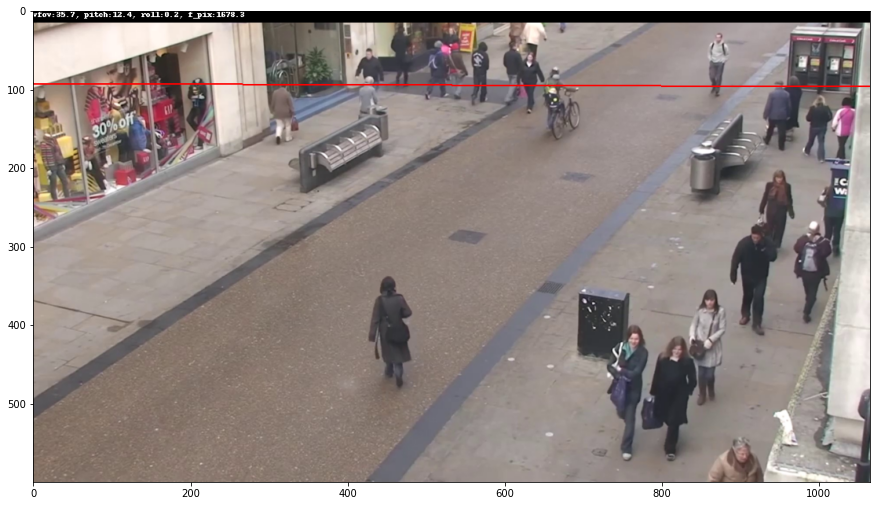

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


In [29]:
from PIL import Image
import matplotlib.pyplot as plt

loss_type = 'softargmax_l2'

with torch.no_grad():

    # Create dataloader list
    dataloader = []

    # Load image into dataloader
    image_list = [str(os.path.join(screenshot_dir,filename))]

    val_dataset = ImageFolder(image_list)

    model = CameraRegressorNetwork(
        backbone='resnet50',
        num_fc_layers=1,
        num_fc_channels=1024,
    ).to(device)

    camcalib_ckpt = torch.load(CKPT)
    camcalib_model = load_pretrained_model(model, camcalib_ckpt['state_dict'], remove_lightning=True, strict=True)

    logger.info('Loaded pretrained model')
    model.eval()

    focal_length = []

    logger.info('Running CamCalib')

    # Extract camera parameters across batch images (if multiple images)
    for idx, batch in enumerate(tqdm(val_dataset)):

        img_fname = batch['imgname']

        image_spec = batch['img'].unsqueeze(0).to(device).float()

        preds = camcalib_model(image_spec)
        preds_distributions = preds

        batch_img = image_spec
        batch_img = denormalize_images(batch_img) * 255
        batch_img = np.transpose(batch_img.cpu().numpy(), (0,2,3,1))

        extract = lambda x:x.detach().cpu().numpy().squeeze()
        img = batch_img[0].copy()

        if loss_type in ('kl', 'ce'):
            pred_vfov, pred_pitch, pred_roll = map(extract, preds)
            pred_vfov, pred_pitch, pred_roll = convert_preds_to_angles(
                                                pred_vfov, pred_pitch, pred_roll, loss_type=loss_type,
                                                return_type='np',)
        else:
            preds = convert_preds_to_angles(*preds, loss_type=loss_type,)
            pred_vfov = extract(preds[0])
            pred_pitch = extract(preds[1])
            pred_roll = extract(preds[2])
        
        orig_img_w, orig_img_h = batch['orig_shape']

        pred_f_pix = orig_img_h / 2. / np.tan(pred_vfov/2.)

        pitch = np.degrees(pred_pitch)
        roll = np.degrees(pred_roll)
        vfov = np.degrees(pred_vfov)

        # Save results into dictionary
        results = {}
        results['vfov'] = float(pred_vfov)
        results['f_pix'] = float(pred_f_pix)
        results['pitch'] = float(pred_pitch)
        results['roll'] = float(pred_roll)

        print("VFOV: {} rad".format(results['vfov']))
        print("Focal Length: {} px".format(results['f_pix']))
        print("Cam Pitch: {} rad".format(results['pitch']))
        print("Cam Roll: {} rad".format(results['roll']))
       
        focal_length.append(pred_f_pix)

        # Display horizontal line
        img, _ = show_horizon_line(img.copy(), pred_vfov, pred_pitch, pred_roll, focal_length=pred_f_pix,
                                   debug=True, color=(255, 0, 0), width=3, GT=False)
        
        plt.figure(figsize=[15,15])
        plt.imshow(img)
        plt.show()


## Geometric Projection Functions

In [30]:
from utils_geometry.transformations import rotation_matrix

def modified_matrices_calculate_range_output_without_translation(height, width, overhead_hmatrix,
                                                                 verbose=False):
    range_u = np.array([np.inf, -np.inf])
    range_v = np.array([np.inf, -np.inf])

    i = 0
    j = 0
    u, v, w = np.dot(overhead_hmatrix, [j, i, 1])
    u = u / w
    v = v / w
    out_upperpixel = v
    if verbose:
        print(u, v)
    range_u[0] = min(u, range_u[0])
    range_v[0] = min(v, range_v[0])
    range_u[1] = max(u, range_u[1])
    range_v[1] = max(v, range_v[1])
    i = height - 1
    j = 0
    u, v, w = np.dot(overhead_hmatrix, [j, i, 1])
    u = u / w
    v = v / w
    out_lowerpixel = v
    if verbose:
        print(u, v)
    range_u[0] = min(u, range_u[0])
    range_v[0] = min(v, range_v[0])
    range_u[1] = max(u, range_u[1])
    range_v[1] = max(v, range_v[1])
    i = 0
    j = width - 1
    u, v, w = np.dot(overhead_hmatrix, [j, i, 1])
    u = u / w
    v = v / w
    if verbose:
        print(u, v)
    range_u[0] = min(u, range_u[0])
    range_v[0] = min(v, range_v[0])
    range_u[1] = max(u, range_u[1])
    range_v[1] = max(v, range_v[1])
    i = height - 1
    j = width - 1
    u, v, w = np.dot(overhead_hmatrix, [j, i, 1])
    u = u / w
    v = v / w
    if verbose:
        print(u, v)
    range_u[0] = min(u, range_u[0])
    range_v[0] = min(v, range_v[0])
    range_u[1] = max(u, range_u[1])
    range_v[1] = max(v, range_v[1])

    range_u = np.array(range_u, dtype=np.int)
    range_v = np.array(range_v, dtype=np.int)

    # it means that while transforming, after some bottom lower image was transformed,
    # upper output pixels got greater than lower
    if out_upperpixel > out_lowerpixel:

        # range_v needs to be updated
        max_height = height * 3
        upper_range = out_lowerpixel
        best_lower = upper_range  # since out_lowerpixel was lower value than out_upperpixel
        #                           i.e. above in image than out_lowerpixel
        x_best_lower = np.inf
        x_best_upper = -np.inf

        for steps_h in range(2, height):
            temp = np.dot(overhead_hmatrix, np.vstack(
                (np.arange(0, width), np.ones((1, width)) * (height - steps_h), np.ones((1, width)))))
            temp = temp / temp[2, :]

            lower_range = temp.min(axis=1)[1]
            x_lower_range = temp.min(axis=1)[0]
            x_upper_range = temp.max(axis=1)[0]
            if x_lower_range < x_best_lower:
                x_best_lower = x_lower_range
            if x_upper_range > x_best_upper:
                x_best_upper = x_upper_range

            if (upper_range - lower_range) > max_height:  # enforcing max_height of destination image
                lower_range = upper_range - max_height
                break
            if lower_range > upper_range:
                lower_range = best_lower
                break
            if lower_range < best_lower:
                best_lower = lower_range
            if verbose:
                print(steps_h, lower_range, x_best_lower, x_best_upper)
        range_v = np.array([lower_range, upper_range], dtype=np.int)

        # for testing
        range_u = np.array([x_best_lower, x_best_upper], dtype=np.int)

    return range_u, range_v
    
def get_overhead_hmatrix_from_4cameraparams(fx, fy, my_tilt, my_roll, img_dims, verbose=False):
    width, height = img_dims

    origin, xaxis, yaxis, zaxis = [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]
    K3x3 = np.array([[fx, 0, width / 2],
                     [0, fy, height / 2],
                     [0, 0, 1]])

    inv_K3x3 = np.linalg.inv(K3x3)
    if verbose:
        print("K3x3:\n", K3x3)

    R_overhead = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
    if verbose:
        print("R_overhead:\n", R_overhead)

    R_slant = rotation_matrix((pi / 2) + my_tilt, xaxis)[:3, :3]
    if verbose:
        print("R_slant:\n", R_slant)

    R_roll = rotation_matrix(my_roll, zaxis)[:3, :3]

    middle_rotation = np.dot(R_overhead, np.dot(np.linalg.inv(R_slant), R_roll))

    overhead_hmatrix = np.dot(K3x3, np.dot(middle_rotation, inv_K3x3))
    est_range_u, est_range_v = modified_matrices_calculate_range_output_without_translation(height, width,
                                                                                            overhead_hmatrix,
                                                                                            verbose=False)

    if verbose:
        print("Estimated destination range: u=", est_range_u, "v=", est_range_v)

    moveup_camera = np.array([[1, 0, -est_range_u[0]], [0, 1, -est_range_v[0]], [0, 0, 1]])
    if verbose:
        print("moveup_camera:\n", moveup_camera)

    overhead_hmatrix = np.dot(moveup_camera, np.dot(K3x3, np.dot(middle_rotation, inv_K3x3)))
    if verbose:
        print("overhead_hmatrix:\n", overhead_hmatrix)

    return overhead_hmatrix, est_range_u, est_range_v
    
def get_scaled_homography(H, target_height, estimated_xrange, estimated_yrange):
    # if don't want to scale image, then pass target_height = np.inf

    current_height = estimated_yrange[1] - estimated_yrange[0]
    target_height = min(target_height, current_height)
    (tw, th) = int(np.round((estimated_xrange[1] - estimated_xrange[0]))), int(
        np.round((estimated_yrange[1] - estimated_yrange[0])))

    tr = target_height / float(th)
    target_dim = (int(tw * tr), target_height)

    scaling_matrix = np.array([[tr, 0, 0], [0, tr, 0], [0, 0, 1]])
    scaled_H = np.dot(scaling_matrix, H)

    return scaled_H, target_dim

In [31]:
from math import radians, pi
import numpy as np

# Test with different parameters
# fx = 2349.595
# fy = 1662.2         #1700.688
# roll_from_horizon = 0 #-0.4013
# my_tilt = 0.628319 #0.43695
# orig_width = 1920
# orig_height = 1080

# Obtain overhead birds-eye-view projection.
overhead_hmatrix, est_range_u, est_range_v = get_overhead_hmatrix_from_4cameraparams(fx=results['f_pix'], fy=results['f_pix'],
                                                                                         my_tilt=results['vfov'],
                                                                                         my_roll=-radians(
                                                                                             results['roll']),
                                                                                         img_dims=(orig_img_w,
                                                                                                   orig_img_h),
                                                                                         verbose=True)

scaled_overhead_hmatrix, target_dim = get_scaled_homography(overhead_hmatrix, orig_img_h*2, est_range_u, est_range_v)
print(f'Target Dimensions: {target_dim}')
output_dim = (orig_img_w, orig_img_h)
print(f'scaled overhead hmatrix:\n{scaled_overhead_hmatrix}')

K3x3:
 [[     1678.3           0         960]
 [          0      1678.3         540]
 [          0           0           1]]
R_overhead:
 [[ 1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]]
R_slant:
 [[          1           0           0]
 [          0    -0.58314    -0.81237]
 [          0     0.81237    -0.58314]]
Estimated destination range: u= [-2023  3940] v= [-4676  -702]
moveup_camera:
 [[   1    0 2023]
 [   0    1 4676]
 [   0    0    1]]
overhead_hmatrix:
 [[    0.99991       1.444    -0.15669]
 [-0.00019852      3.1079     0.14842]
 [-3.0919e-08  0.00048404     0.32178]]
Target Dimensions: (3241, 2160)
scaled overhead hmatrix:
[[    0.54348     0.78484   -0.085164]
 [ -0.0001079      1.6893    0.080673]
 [-3.0919e-08  0.00048404     0.32178]]


/home/user/anaconda3/envs/itss/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/user/anaconda3/envs/itss/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note l

Homography Matrix: [[     1.4392      2.1527     -944.03]
 [  -0.027683      6.1859     -1042.5]
 [ 0.00012455   0.0025643           1]]
Auto Homography Matrix: [[    0.98075      1.7507      -474.6]
 [  -0.039406      3.5647     -933.96]
 [-1.3082e-05   0.0011834   -0.029549]]
screenshots/TownCentre_short.jpg


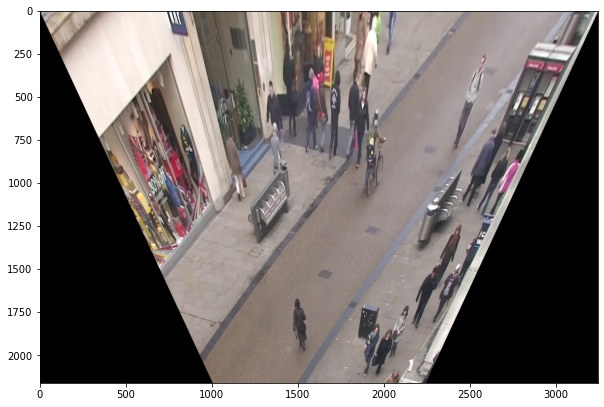

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 4 point pairs - p1, p2, p3, p4
points_birdseye = [[400,695],[828,770],[325,1181],[716,1263]]
points_image = [[634,411],[1316,469],[231,717],[1031,847]]

# overhead_hmat2 =  np.array([[ 5.53137004e-01,  7.95275169e-01, -3.79599419e-02],
#                     [  0.00000000e+00,  1.70191583e+00, -1.69922959e-01],
#                     [  0.00000000e+00,  4.86714426e-04,  3.24959842e-01]])

overhead_hmat_scaled_oxford = np.array([[1.916320439247891638e-01, 7.175533976911367962e-01, -1.133240359600345970e-02],
                                [7.170477613692259090e-03, 1.414341738339534471e+00, -9.603207928416342826e-03],
                                [2.700896605900791288e-06, 5.327386830370514463e-04, 1.329097656281789108e-01]])

overhead_hmat_scaled_applestore = np.array([[9.807476724575517890e-01, 1.750721563034322026e+00, -4.745960040713702028e+02],
                                [-3.940559474104118193e-02, 3.564696575623830466e+00, -9.339590536839616561e+02],
                                [-1.308161370635335059e-05, 1.183384843931921306e-03, -2.954917251000888090e-02]])

overhead_hmat_scaled_malldataset = np.array([[3.885117170374643991e-01, 6.311962088298972429e-01, -2.322080847492125760e-02],
                                [5.999403272761874573e-02, 2.460310377305638507e+00, -1.470834138767576627e-02],
                                [2.030447787618721710e-05, 8.326714400307154212e-04, 1.515470521987219432e-01]])

# Get homography matrix through manual annotation
h_mat, status = cv2.findHomography(np.array(points_image), np.array(points_birdseye))
print(f'Homography Matrix: {h_mat}')
print(f'Auto Homography Matrix: {overhead_hmat_scaled_applestore}')

# Read in image screenshot
# img_path = 'homography/OxfordTownCenter.png'
img_path = os.path.join(screenshot_dir,filename)
print(img_path)
img_cv = cv2.imread(img_path)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# Perform perspective warping
manual_dim = (1080,1465)
overhead_dim = (2662,2160)
overhead_dim2 = (2987,1440)
overhead_dim3 = (1508,2160)

# birdeye_pt = cv2.perspectiveTransform(bbox_pt, h_mat)
# warped_image = cv2.warpPerspective(img_cv, h_mat, dsize=manual_dim, flags=cv2.INTER_CUBIC)
# warped_image = cv2.warpPerspective(img_cv, overhead_hmat_scaled_malldataset, dsize=overhead_dim3, flags=cv2.INTER_CUBIC)

warped_image = cv2.warpPerspective(img_cv, scaled_overhead_hmatrix, dsize=target_dim, flags=cv2.INTER_CUBIC)
plt.figure(figsize=[10,10])
plt.imshow(warped_image)
plt.show()
# plt.imsave('OxfordBirdsEye_HighRes.jpg', warped_image)

In [33]:
# Resize image function
def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in im_list]
    return cv2.hconcat(im_list_resize)

# Run Detector and Tracker, followed by Homography transformation to birds eye view

In [34]:
import cv2
import numpy as np

# Use Manual h_mat
# height = 1465
# width = 1080

# Use Auto h_mat
# height = 2160
# width = 2662
height = target_dim[1]
width = target_dim[0]
scale_resize = 50

with torch.no_grad():
    for frame_idx, (path, img, im0s, vid_cap, s) in enumerate(dataset):

        # Create a blank map canvas every frame
        map_image = np.zeros((height,width,3), np.uint8)

        t1 = time_sync()
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)
        t2 = time_sync()
        dt[0] += t2 - t1

        # Inference
        visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visual else False
        pred = model_yolo(img, augment=augment, visualize=visualize)
        t3 = time_sync()
        dt[1] += t3 - t2

        # Apply NMS
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
        dt[2] += time_sync() - t3

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            seen += 1
            p, im0, _ = path, im0s.copy(), getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # im.jpg, vid.mp4, ...
            s += '%gx%g ' % img.shape[2:]  # print string

            # annotator = Annotator(im0, line_width=2, pil=not ascii)

            if det is not None and len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(
                    img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                xywhs = xyxy2xywh(det[:, 0:4])
                confs = det[:, 4]
                clss = det[:, 5]

                # pass detections to deepsort
                t4 = time_sync()
                outputs = deepsort.update(xywhs.cpu(), confs.cpu(), clss.cpu(), im0)
                t5 = time_sync()
                dt[3] += t5 - t4

                # draw boxes for visualization
                if len(outputs) > 0:
                    for j, (output, conf) in enumerate(zip(outputs, confs)):

                        bboxes = output[0:4]
                        id = output[4]
                        cls = output[5]

                        # Box definitions
                        x = int(output[0])
                        y = int(output[1])
                        w = int(output[2] - output[0])
                        h = int(output[3] - output[1])
                        bbox_int = x,y,w,h

                        c = int(cls)  # integer class
                        label = f'ID:{id} ({conf:.2f})'

                        # Write Track ID on target base
                        cv2.putText(im0,str(id),(x,y+h+20), 0, 400*1e-3*2, [255,255,255], 2)

                        # Comment out this portion and draw our own boxes
                        # annotator.box_label(bboxes, label, color=colors(c, True))

                        # Compute box base - Homography transformation
                        bbox_pt = np.array([(int(output[0] + (output[2] - output[0])/2), int(output[1]))], dtype='float32')
                        bbox_pt = np.array([bbox_pt], dtype='float32')

                        # Obtain corresponding birdseye point transformation
                        # - manual h_mat
                        # - auto h_mat (overhead_hmat)
                        # birdseye_pt = cv2.perspectiveTransform(bbox_pt, h_mat)
                        birdseye_pt = cv2.perspectiveTransform(bbox_pt, scaled_overhead_hmatrix)                        
                        map_pt = (int(birdseye_pt[0][0][0]), int(birdseye_pt[0][0][1]))

                        # Draw point on 2d plane
                        cv2.circle(map_image, map_pt, 15, (0,0,255), -2)

                        if save_txt:
                            # to MOT format
                            bbox_left = output[0]
                            bbox_top = output[1]
                            bbox_w = output[2] - output[0]
                            bbox_h = output[3] - output[1]
                            # Write MOT compliant results to file
                            with open(txt_path, 'a') as f:
                                f.write(('%g ' * 10 + '\n') % (frame_idx + 1, id, bbox_left,  # MOT format
                                                                bbox_top, bbox_w, bbox_h, -1, -1, -1, -1))

                LOGGER.info(f'{s}Done. YOLO:({t3 - t2:.3f}s), DeepSort:({t5 - t4:.3f}s)')

            else:
                deepsort.increment_ages()
                LOGGER.info('No detections')

            # Plot results by joining the images together
            # scale and resize the image smaller for display
            final_image_joined = hconcat_resize_min([im0, map_image])
            resize_w = int(final_image_joined.shape[1] * scale_resize/100)
            resize_h = int(final_image_joined.shape[0] * scale_resize/100)
            resize_dim = (resize_w, resize_h)
            resized_image = cv2.resize(final_image_joined, resize_dim, interpolation=cv2.INTER_AREA)

            cv2.imshow(str(p), resized_image)
            if cv2.waitKey(1) == ord('q'):  # q to quit
                raise StopIteration

            # # Stream results
            # im0 = annotator.result()
            # if show_vid:
            #     cv2.imshow(str(p), im0)
            #     if cv2.waitKey(1) == ord('q'):  # q to quit
            #         raise StopIteration

        # img_out = sd.proximity_evaluation(trackid_bbox_centroid, im0, cam)

        # # Plot results
        # cv2.imshow(str(p), output_img)
        # if cv2.waitKey(1) == ord('q'):  # q to quit
        #     raise StopIteration

            # Save results (image with detections)
            if save_vid:
                if vid_path != save_path:  # new video
                    vid_path = save_path
                    if isinstance(vid_writer, cv2.VideoWriter):
                        vid_writer.release()  # release previous video writer
                    # if vid_cap:  # video
                    #     fps = vid_cap.get(cv2.CAP_PROP_FPS)
                    #     w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                    #     h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    # else:  # stream
                    fps, w, h = 30, resized_image.shape[1], resized_image.shape[0]

                    # fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
                    vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h), True)
                vid_writer.write(resized_image)
    
    vid_cap.release()
    vid_writer.release()
    cv2.destroyAllWindows()

video 1/1 (1/1523) /media/user/New Volume/MTech/ITSS/OxfordTownCenter/TownCentre_short.mp4: 384x640 36 persons, Done. YOLO:(0.045s), DeepSort:(0.082s)
QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to target thread (0x5604fa713660)

QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to target thread (0x5604fa713660)

QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to target thread (0x5604fa713660)

QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to target thread (0x5604fa713660)

QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to target thread (0x5604fa713660)

QObject::moveToThread: Current thread (0x5604fa713660) is not the object's thread (0x5604f9542ec0).
Cannot move to